In [14]:
import os
from numpy import genfromtxt
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from scipy.signal import resample

from data_organizer_Kfall import DataOrganizer
# import torch
#from torch import nn
#from torch.utils.data import DataLoader
#from torch.utils.data import TensorDataset, DataLoader
#from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix
# from utils import train, test
import keras
from keras.models import Sequential
from keras.layers import Conv1D, BatchNormalization, ReLU, Softmax, MaxPooling1D, LSTM, Dropout, Dense
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
# import flatten
from keras.layers import Flatten


# Data Loader

In [5]:
# mac
#sensor_data_folder = '/Users/liuxinqing/Documents/Kfall/sensor_data'  # Update with the path to sensor data
#label_data_folder = '/Users/liuxinqing/Documents/Kfall/label_data'  
# windows 
# sensor_data_folder = 'G:\MLonMCU\Kfall_dataset\sensor_data'  # Update with the path to sensor data
# label_data_folder = 'G:\MLonMCU\Kfall_dataset\label_data' 
# linux
sensor_data_folder = '/home/liyinrong/Projects/MLonMCU/Final/Fall_Detection/datasets/KFall/sensor_data'  # Update with the path to sensor data
label_data_folder = '/home/liyinrong/Projects/MLonMCU/Final/Fall_Detection/datasets/KFall/label_data'  

#window_size = 256
# Kfall: window_size = 50
window_size = 50
threshold = 0.4
num_window_fall_data = 50
num_window_not_fall_data = 5

data, label = DataOrganizer(sensor_data_folder, 
                            label_data_folder, 
                            window_size, 
                            threshold, 
                            num_window_fall_data, 
                            num_window_not_fall_data)

Processing 1/32 folder...
Processing 2/32 folder...
Processing 3/32 folder...
Processing 4/32 folder...
Processing 5/32 folder...
Processing 6/32 folder...
Processing 7/32 folder...
Processing 8/32 folder...
Processing 9/32 folder...
Processing 10/32 folder...
Processing 11/32 folder...
Processing 12/32 folder...
Processing 13/32 folder...
Processing 14/32 folder...
Processing 15/32 folder...
Processing 16/32 folder...
Processing 17/32 folder...
Processing 18/32 folder...
Processing 19/32 folder...
Processing 20/32 folder...
Processing 21/32 folder...
Processing 22/32 folder...
Processing 23/32 folder...
Processing 24/32 folder...
Processing 25/32 folder...
Processing 26/32 folder...
Processing 27/32 folder...
Processing 28/32 folder...
Processing 29/32 folder...
Processing 30/32 folder...
Processing 31/32 folder...
Processing 32/32 folder...


In [8]:
in_channels = data.shape[2]
print('in_channels: ', in_channels)
# the input data should have the shape (batch_size, in_channels, sequence_length)
#data = data.reshape(data.shape[0], in_channels, -1)
print('data.shape: ', data.shape)

in_channels:  9
data.shape:  (25571, 50, 9)


In [9]:
label = label.astype(np.int64)
# one-hot encoding
#label = to_categorical(label, num_classes=2)
# transpose the data to (batch_size, sequence_length, in_channels)
#data = np.transpose(data, (0, 2, 1))
# data = data.reshape(data.shape[0], 50, 9)
# (y == 0).sum()
B_size = (label == 0).sum()
A_size = (label == 1).sum()
print('B_size: ', B_size)	
print('A_size: ', A_size)
# transpose the data to (batch_size, in_channels, sequence_length)
#data = np.transpose(data, (0, 2, 1))
print('data.shape: ', data[0][0])
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#print(np.unique(y_train)) # [0 1]
y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)


# select the test data that is not zero
X_test_true = X_test[y_test != 0]
y_test_true = y_test[y_test != 0]
# length of the test data
test_len = X_test_true.shape[0]
X_test_false = X_test[y_test == 0]
y_test_false = y_test[y_test == 0]
# X_test.shape:  (17, 50, 9)
# randomly len number of test data that is zero
index = np.random.choice(X_test_false.shape[0], test_len, replace=False)
# X_test.shape:  (17, 50, 9)
# randomly len number of test data that is zero
#index = np.random.choice(X_test_false.shape[0], len, replace=False)


X_test_false = X_test[index]
y_test_false = y_test[index]

# concatenate the true and false test data
X_test = np.concatenate((X_test_true, X_test_false), axis=0)
y_test = np.concatenate((y_test_true, y_test_false), axis=0)
#X_test = X_test[y_test != 0]
#y_test = y_test[y_test != 0]
print(X_test.shape)



# device = (
#      "cuda"
#      if torch.cuda.is_available()
#      else "cpu"
#  )
# #device = "cpu"
# print(f"Using {device} device")

B_size:  25020
A_size:  551
data.shape:  [ 6.20000000e-02 -9.93000000e-01 -3.90000000e-02  2.00535300e+00
  9.74028600e-01 -9.16732800e-01  8.72557738e+01  3.42055926e+00
  3.17418732e+00]
(228, 50, 9)


# Hyperparameters

In [10]:
# Hyperparameters
learning_rate = 5e-4
batch_size = 64
epochs = 50
patience = 5

# ConvLSTM

In [21]:
ConvLSTM = Sequential([
    # Conv1
    Conv1D(filters=64, kernel_size=3, padding='same', input_shape=(50, 9)),
    BatchNormalization(),
    ReLU(),
    MaxPooling1D(2),

    # Conv2
    Conv1D(filters=64, kernel_size=3, padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling1D(2),

    # Conv3
    Conv1D(filters=64, kernel_size=3, padding='same'),
    BatchNormalization(),
    ReLU(),
    MaxPooling1D(2),

    # LSTM layers
    LSTM(64, return_sequences=True),
    Dropout(0.5),
    LSTM(64),
    Dropout(0.5),
    # flatten
    Flatten(),
    # Fully connected layer
    Dense(32),
    # relu
    ReLU(),
    Dense(2),
    ReLU(),
    # softmax
    Dense(2, activation='softmax')
])

# ConvLSTM = Sequential([
#     # Conv1
#     Conv1D(filters=64, kernel_size=7, padding='same', input_shape=(50, 9)),
#     BatchNormalization(),
#     ReLU(),
#     MaxPooling1D(2),

#     # Conv2
#     Conv1D(filters=64, kernel_size=7, padding='same'),
#     BatchNormalization(),
#     ReLU(),
#     MaxPooling1D(2),

#     # Conv3
#     Conv1D(filters=64, kernel_size=7, padding='same'),
#     BatchNormalization(),
#     ReLU(),
#     MaxPooling1D(2),

#     # LSTM layers
#     LSTM(64, return_sequences=True),
#     Dropout(0.5),
#     LSTM(64),
#     Dropout(0.5),
    
#     # Fully connected layer
#     Flatten(),
#     Dense(32, activation='relu'),
#     Dense(2, activation='relu'),
    
#     # softmax
#     Softmax()
# ])

In [22]:
# Create an instance of the model
# Create an instance of the model
#model_ConvLSTM = ConvLSTM().to(device)
#loss_fn = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model_ConvLSTM.parameters(), lr=learning_rate)
# Initialize the scheduler
#scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=patience, verbose=True)
print(f"Model structure: \n")
ConvLSTM.summary()

""" for layer in ConvLSTM.layers:
    weights = layer.get_weights()
    print(f"Layer: {layer.name} | Weights: {weights} \n") """

Model structure: 



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 50, 64)            │      1,792 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_12          │ (None, 50, 64)            │        256 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ re_lu_14 (ReLU)                 │ (None, 50, 64)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 25, 64)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_13 (Conv1D)              │ (None, 25, 64)            │     12,352 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_13          │ (None, 25, 64)            │        256 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ re_lu_15 (ReLU)                 │ (None, 25, 64)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 12, 64)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv1d_14 (Conv1D)              │ (None, 12, 64)            │     12,352 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_14          │ (None, 12, 64)            │        256 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ re_lu_16 (ReLU)                 │ (None, 12, 64)            │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 6, 64)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ lstm_8 (LSTM)                   │ (None, 6, 64)             │     33,024 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_8 (Dropout)             │ (None, 6, 64)             │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)                │     33,024 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_9 (Dropout)             │ (None, 64)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten_4 (Flatten)             │ (None, 64)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_9 (Dense)                 │ (None, 32)                │      2,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ re_lu_17 (ReLU)                 │ (None, 32)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_10 (Dense)                │ (None, 2)                 │         66 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ re_lu_18 (ReLU)                 │ (None, 2)                 │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_11 (Dense)                │ (None, 2)                 │          6 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 95,464 (372.91 KB)

 Trainable params: 95,080 (371.41 KB)

 Non-trainable params: 384 (1.50 KB)

' for layer in ConvLSTM.layers:\n    weights = layer.get_weights()\n    print(f"Layer: {layer.name} | Weights: {weights} \n") '

In [23]:
""" train(train_dataloader, model_ConvLSTM, loss_fn, optimizer,val_dataloader, 
           patience=patience, scheduler=scheduler, epochs=epochs, device=device, B_size=B_size, A_size=A_size) """
# Train the model
# Train the model without using batches
# Compile the model
# Ensure y_train and y_val are one-hot encoded only once
if y_train.ndim == 1:
    y_train = to_categorical(y_train)
if y_val.ndim == 1:
    y_val = to_categorical(y_val)
print('y_train.shape: ', y_train.shape)
print('y_val.shape: ', y_val.shape)

# Calculate class weights
B_multiplier = 1
A_multiplier = B_size / A_size
class_weight = {0: B_multiplier, 1: A_multiplier}


ConvLSTM.compile(optimizer='adam', 
                loss='categorical_crossentropy',
                #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
# Ensure y_train and y_val are one-hot encoded only once
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
print('X_train.shape: ', X_train.shape) # (23291, 50, 9)
print('y_train.shape: ', y_train.shape) # (23291,)

history = ConvLSTM.fit(X_train, y_train, 
          validation_data=(X_val, y_val), 
          epochs=epochs, 
          batch_size=batch_size,
          callbacks=[es],
          class_weight=class_weight) 

y_train.shape:  (16364, 2)
y_val.shape:  (4092, 2)
X_train.shape:  (16364, 50, 9)
y_train.shape:  (16364, 2)
Epoch 1/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 24s 79ms/step - accuracy: 0.8006 - loss: 1.1024 - val_accuracy: 0.7979 - val_loss: 0.3900
Epoch 2/50
138/256 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.8148 - loss: 0.6112

KeyboardInterrupt: 

In [134]:
# Evaluate the model

print('X_test.shape: ', X_test.shape)
if y_test.ndim == 1:
    y_test = to_categorical(y_test)
test_loss = ConvLSTM.evaluate(X_test, y_test, verbose=2)
print('Test loss:', test_loss)

X_test.shape:  (192, 50, 9)
6/6 - 0s - loss: 0.1861 - accuracy: 0.9427 - 37ms/epoch - 6ms/step
Test loss: [0.1860751360654831, 0.9427083134651184]


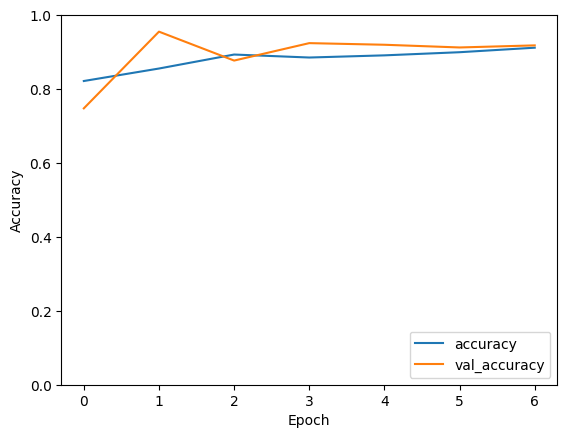

In [135]:
# Plot the training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [136]:
# plot the confusion matrix for the quantized model
from sklearn.metrics import confusion_matrix
import itertools

"""
function: plot_confusion_matrix
    - input: cm, classes, normalize, title, cmap
    - output: none
    - description: plots the confusion matrix
"""

def plot_confusion_matrix(cm, classes,
                            normalize=False,
                            title='Confusion matrix',
                            cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

6/6 [==============================] - 0s 4ms/step
[[89  7]
 [ 4 92]]
Confusion matrix, without normalization
[[89  7]
 [ 4 92]]


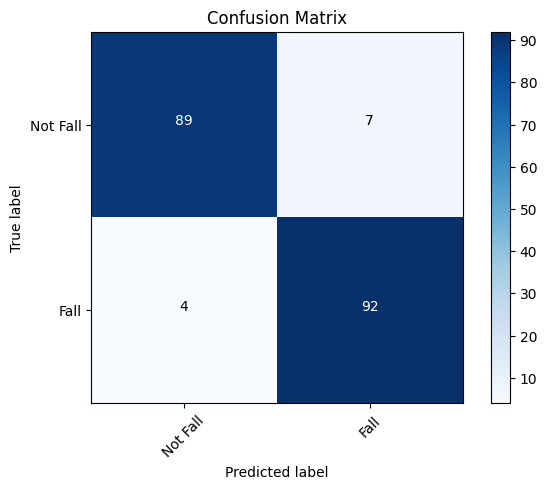

In [138]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Convert y_test back to its original form
y_test_original = np.argmax(y_test, axis=-1)

# Get the model's predictions
predictions = np.argmax(ConvLSTM.predict(X_test), axis=-1)

# Compute the confusion matrix
cm = confusion_matrix(y_test_original, predictions)

print(cm)
# plot the confusion matrix
plot_confusion_matrix(cm, classes=['Not Fall', 'Fall'], normalize=False, title='Confusion Matrix')